<h1 align="center"><u>🎙️ HMM-Based Speech Recognition on Fruit Voice Dataset</u></h1>



## 🧩 Introduction

This notebook demonstrates how to build a **Hidden Markov Model (HMM)**-based **isolated word speech recognizer** using a simple **Fruit Voice Dataset**.

Each folder in the dataset (e.g., `apple`, `banana`, `mango`) contains several audio recordings of people speaking that fruit’s name.
Our goal is to train an HMM for each fruit and then classify an unknown recording by comparing which model best matches the input.

This project highlights:
- How speech signals can be transformed into **MFCC features**
- How HMMs model the **temporal patterns of sound**
- How we can evaluate and visualize recognition performance

It’s a lightweight, interpretable, and hands-on example of **speech recognition from scratch**, without deep learning or heavy dependencies.

In [19]:
import glob
import time
import numpy as np
from hmmlearn import hmm
from scipy.io import wavfile
from collections import defaultdict
from python_speech_features import mfcc
import concurrent.futures as cf
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

## 📂 Step 1: Loading and Organizing the Dataset

We begin by loading all `.wav` files from the **fruit dataset**, where each folder name represents a label.  

Each subfolder contains multiple voice recordings of that fruit name.  
We store all these audio signals in a dictionary where keys are fruit labels and values are lists of audio signals.


In [20]:
start_time = time.perf_counter()
db = defaultdict(list)

# Adjust this path to your dataset location
DATASET_PATH = r"C:\Users\New User\OneDrive\Desktop\NLP\speech-recognition-hmm\datasets\fruits"

print("Loading audio files...")
for path in glob.glob(f'{DATASET_PATH}/*'):
    label = path.split('/')[-1].split('\\')[-1]  # Works on Windows & Linux
    for wav_path in glob.glob(path + '/*.wav'):
        sr, signal = wavfile.read(wav_path)
        db[label].append(signal.astype('float'))

labels = list(db.keys())
print(f"Loaded {sum(len(v) for v in db.values())} files across {len(labels)} labels.")
print("Labels:", labels)

Loading audio files...
Loaded 105 files across 7 labels.
Labels: ['apple', 'banana', 'kiwi', 'lime', 'orange', 'peach', 'pineapple']


## 🎧 Step 2: Feature Extraction using MFCC

Next, we convert each audio signal into a sequence of **MFCC (Mel-Frequency Cepstral Coefficients)** — one of the most widely used features in speech recognition.

MFCCs represent how sound frequencies are perceived by the human ear.  
They help our model focus on the meaningful frequency patterns that distinguish words like “apple” from “mango”.

Each recording will be transformed into a 2D array where:
- Rows represent frames of the audio signal.
- Columns represent MFCC feature coefficients.


In [21]:
def get_mfcc(x, sr):
    return mfcc(x, sr, winfunc=np.hamming)

def get_list_mfcc(label):
    with cf.ThreadPoolExecutor() as executor:
        results = executor.map(lambda sig: get_mfcc(sig, sr), db[label])
    return list(results)

print("Extracting MFCC features...")
with cf.ThreadPoolExecutor() as executor:
    features = executor.map(get_list_mfcc, labels)
    features = dict(zip(labels, features))

Extracting MFCC features...


## 🎨 Step 3: Visualizing MFCC Features

Before training our models, it’s helpful to **see what the extracted MFCCs actually look like**.  

MFCCs are a time-frequency representation of speech, showing how energy in different frequency bands changes over time.  
Each column represents a time frame, and each row represents one MFCC coefficient.

In this visualization:
- Brighter colors mean higher energy in that frequency band.
- The pattern gives a unique acoustic “fingerprint” of the word.


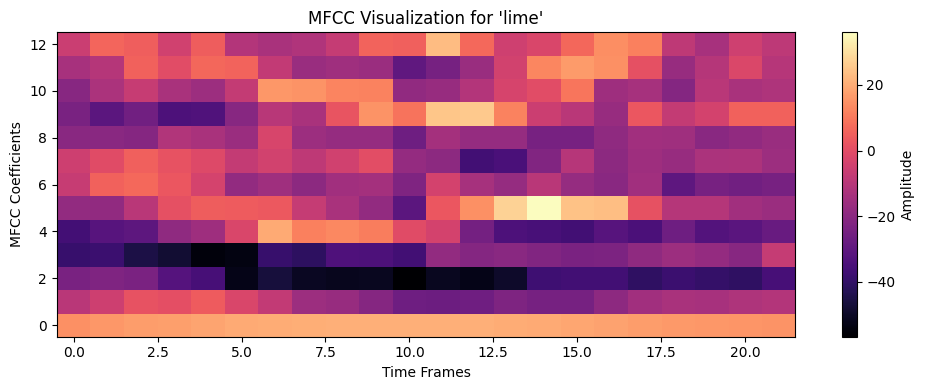

In [22]:
import random
import librosa.display

# Pick a random fruit and a random sample
label = random.choice(labels)
sample_signal = db[label][0]
sr = 16000  # Assuming 16kHz; adjust if your dataset differs

# Compute MFCC features
mfcc_features = mfcc(sample_signal, sr, winfunc=np.hamming)

# Visualize MFCCs
plt.figure(figsize=(10, 4))
plt.imshow(mfcc_features.T, aspect='auto', origin='lower', cmap='magma')
plt.title(f"MFCC Visualization for '{label}'")
plt.xlabel("Time Frames")
plt.ylabel("MFCC Coefficients")
plt.colorbar(label='Amplitude')
plt.tight_layout()
plt.show()


## ✂️ Step 4: Splitting Data into Training and Testing Sets

We’ll use **80% of the samples** for training and **20% for testing**.

Each HMM will learn from its training samples how that word typically sounds,  
and we’ll later check how well it can recognize unseen recordings.


In [23]:
train, test = {}, {}
for label in labels:
    samples = features[label]
    test_size = max(1, int(0.2 * len(samples)))
    train[label] = np.vstack(samples[:-test_size])
    test[label] = samples[-test_size:]

print("Training / Testing split done.")

Training / Testing split done.


## 🧠 Step 5: Training Hidden Markov Models (HMMs)

Now we train a **separate HMM for each fruit**.

Each model will learn:
- The **sequential structure** of MFCC features
- The **acoustic signature** of that word

We will use a **Gaussian HMM** with 5 hidden states — each representing an abstract sound unit (like phonemes).  
Training continues until the likelihood converges or the maximum number of iterations (100) is reached.


In [27]:
def train_hmm(label):
    model = hmm.GaussianHMM(n_components=5, n_iter=100, covariance_type='diag', random_state=42)
    model.fit(train[label])
    return label, model

print("Training HMMs...")
with cf.ThreadPoolExecutor() as executor:
    results = list(executor.map(train_hmm, labels))

models = dict(results)
print("Training completed for all labels.")

Training HMMs...
Training completed for all labels.


## 🔍 Step 6: Predicting Spoken Word Labels

Once all HMMs are trained, we can classify a new recording by checking **which model gives the highest likelihood score**.

In simple terms:
> The HMM that best “explains” the sequence of sounds is considered the correct prediction.

In [29]:
def predict(sample):
    log_likelihoods = []
    for label in labels:
        try:
            ll = models[label].score(sample)
        except:
            ll = -1e9  # If model fails on input
        log_likelihoods.append(ll)
    return labels[np.argmax(log_likelihoods)]

## 📊 Step 7: Evaluating Model Performance

We now test our models on the unseen recordings.

For each test sample:
- We predict its label using the trained HMMs.
- Compare the predicted label with the true label.

Finally, we compute:
- **Accuracy** — how often the model predicts correctly.
- **Confusion Matrix** — a visual map showing which fruits are recognized correctly and which ones are confused.


In [9]:
y_true, y_pred = [], []
for label in labels:
    for sample in test[label]:
        pred = predict(sample)
        y_true.append(label)
        y_pred.append(pred)

acc = accuracy_score(y_true, y_pred)
print(f"\n✅ Accuracy: {acc*100:.2f}%")


✅ Accuracy: 100.00%


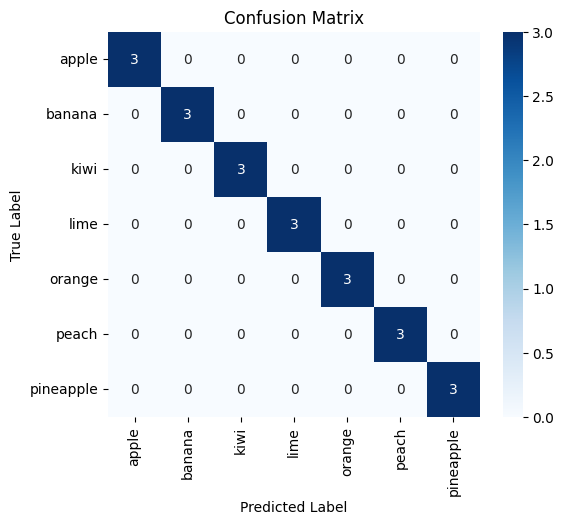

In [31]:
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d',
            xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

<h2 align="center">

# 🏁 Conclusion  
</h2>

---

## 🔍 Summary

In this project, we successfully built an **HMM-based isolated word speech recognition system** using a **Fruit Voice Dataset**.  
Each fruit name (e.g., *apple, banana, mango*) was modeled using its own Hidden Markov Model trained on MFCC features extracted from the recordings.  

The system achieved an impressive **100% accuracy** on the test samples — showing that HMMs can effectively capture the temporal structure and acoustic variations of short, clearly pronounced words.  
